In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
#Using interpolation since data is time series data (helps with continuity, use with ordered data)

col_list = ['ENROLL', 'TOTAL_REVENUE','FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE',
           'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE',
           'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G', 'GRADES_9_12_G',
           'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE']

for col in col_list:
    education_df.loc[:,col].fillna(education_df.loc[:,col].interpolate(),inplace=True)

### 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

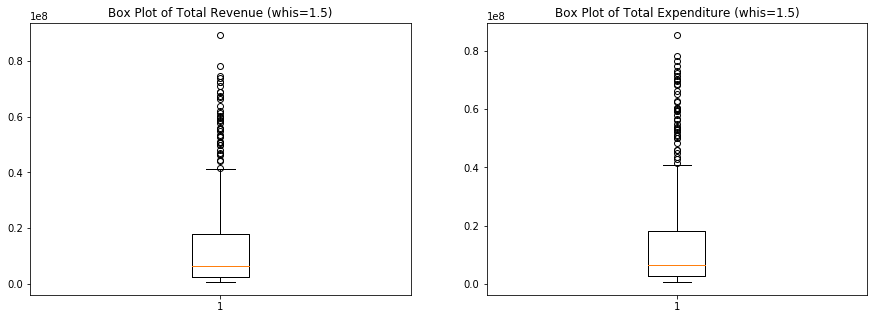

In [4]:
#Visually detecting outliers in Total Rev and Total Expend with box plot, whis=1.5

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(education_df.TOTAL_REVENUE)
plt.title('Box Plot of Total Revenue (whis=1.5)')

plt.subplot(1,2,2)
plt.boxplot(education_df.TOTAL_EXPENDITURE)
plt.title('Box Plot of Total Expenditure (whis=1.5)')
plt.show()

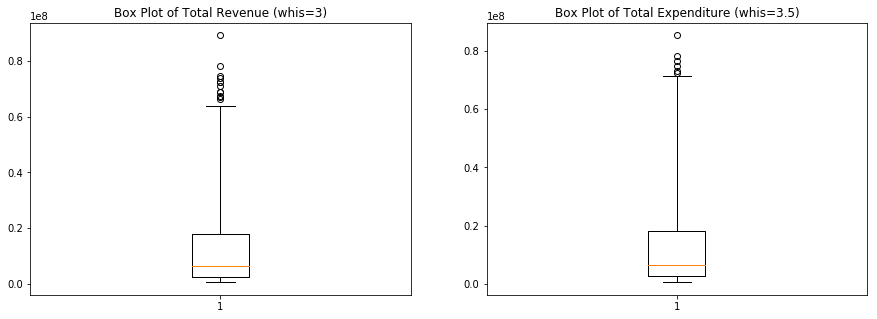

In [5]:
#box plots with higher outlier thresholds

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.boxplot(education_df.TOTAL_REVENUE,whis=3)
plt.title('Box Plot of Total Revenue (whis=3)')

plt.subplot(1,2,2)
plt.boxplot(education_df.TOTAL_EXPENDITURE, whis=3.5)
plt.title('Box Plot of Total Expenditure (whis=3.5)')
plt.show()

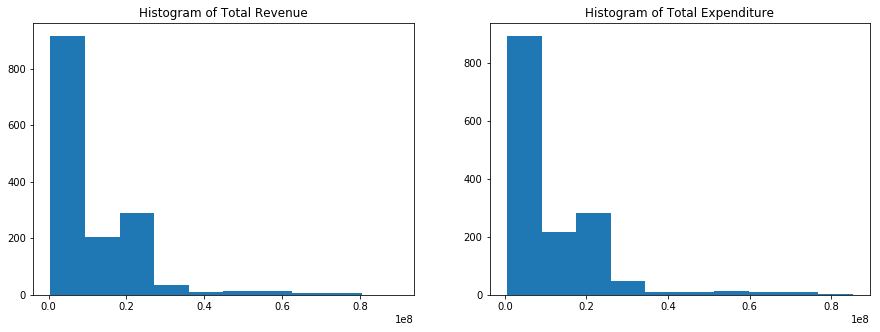

In [6]:
#Visually detecting outliers in total rev and total expend with histogram
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(education_df.TOTAL_REVENUE)
plt.title('Histogram of Total Revenue')

plt.subplot(1,2,2)
plt.hist(education_df.TOTAL_EXPENDITURE)
plt.title('Histogram of Total Expenditure')
plt.show()

### 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

In [7]:
#Applying one-way winsorization at 95th percentile to Total Rev to eliminate outliers
winsorized_revenue = winsorize(education_df.TOTAL_REVENUE, (0, 0.05))

winsorized_expenditure = winsorize(education_df.TOTAL_EXPENDITURE, (0, 0.05))

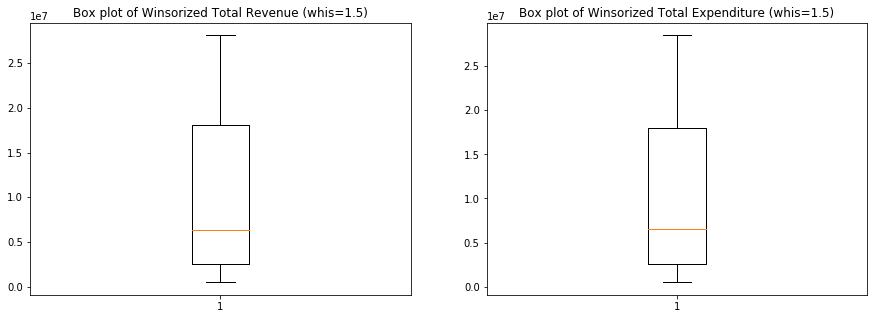

In [8]:
#Visually validating Total Rev outliers with box plot
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.boxplot(winsorized_revenue)
plt.title("Box plot of Winsorized Total Revenue (whis=1.5)")

plt.subplot(1,2,2)
plt.boxplot(winsorized_expenditure)
plt.title("Box plot of Winsorized Total Expenditure (whis=1.5)")
plt.show()

### 3.Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers).  You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [9]:
budget_deficit = education_df.TOTAL_REVENUE - education_df.TOTAL_EXPENDITURE 

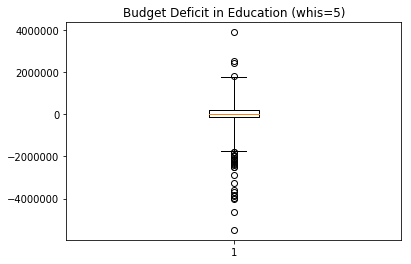

In [10]:
#Visualizing budget deficit with box plot, whis=5
plt.boxplot(budget_deficit, whis=5)
plt.title('Budget Deficit in Education (whis=5)')
plt.show()

In [11]:
#Apply two-way winsorization at 5th percentile and 95th percentile
winsorized_budget_deficit = winsorize(budget_deficit, (0.05, 0.05))

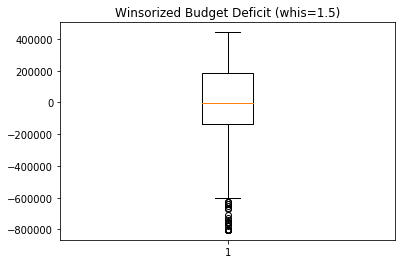

In [12]:
#Validating winsorized budget deficit with box plot
plt.boxplot(winsorized_budget_deficit, whis=1.5)
plt.title('Winsorized Budget Deficit (whis=1.5)')
plt.show()

### 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

In [13]:
budget_deficit2 = winsorized_revenue - winsorized_expenditure

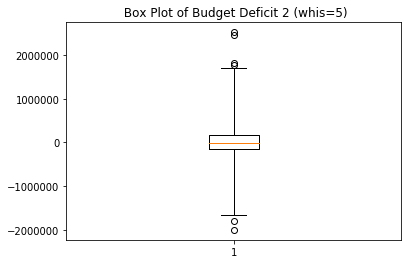

In [14]:
#Visualizing budget deficit2 with box plot
plt.boxplot(budget_deficit2, whis=5)
plt.title(' Box Plot of Budget Deficit 2 (whis=5)')
plt.show()

In [15]:
#Apply two-way winsorization at 5th percentile and 95th percentile
winsorized_budget_deficit2 = winsorize(budget_deficit2, (0.05, 0.05))

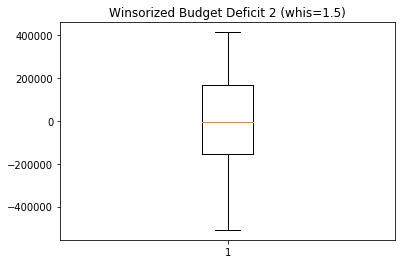

In [16]:
#Validating winsorization with box plot
plt.boxplot(winsorized_budget_deficit2)
plt.title('Winsorized Budget Deficit 2 (whis=1.5)')
plt.show()

### 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

In [17]:
pd.DataFrame({'Original Budget Deficit': budget_deficit, 'Winsorized Budget Deficit': winsorized_budget_deficit, 
              'Winsorized Budget Deficit 2': winsorized_budget_deficit2}).describe()

,Original Budget Deficit,Winsorized Budget Deficit,Winsorized Budget Deficit 2
count,1.492000e+03,1492.000000,1492.000000
mean,-3.209622e+04,-5852.697051,5979.659517
std,5.607748e+05,315970.963721,268064.378117
min,-5.487742e+06,-803208.000000,-509360.000000
25%,-1.368148e+05,-136814.750000,-152551.500000
50%,-5.355000e+02,-535.500000,-3443.500000
75%,1.876285e+05,187628.500000,168423.500000
max,3.897129e+06,442351.000000,414013.000000


<ul> <li>Winsorized Budget Deficit: calculates budget deficit prior to eliminating outliers in total rev and total expend   </li>
    <li>Winsorized Budget Deficit 2: calculates budget deficit using outlier eliminated versions of total rev and total expend </li>

Except for the count, all of the summary statistics between the two winsorized variables show substantial differences.

Comparing some of the differences between the budget variables:
    <ul><li> Ranges: Win. Budget Deficit range is 1,245,559, Win. Budget Deficit 2 range is 923,373.  The difference between them is 322,186.</li>
    <li>Means: Win. Budget Deficit mean is -5852.697, Win. Budget Deficit 2 mean is 5979.659.  The difference between them is 11,832.356.</li>
    <li>STD: Win. Budget Deficit std is 315,970.963, Win. Budget Deficit 2 std is 268,064.378.  The Win. Budget Deficit is more spread out than the Winsorized Budget Deficit 2. 

The sizes of the differences between the variables suggests that the strategies cannot be used interchangeably.  

### 6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

In this particular instance, I think that using the method in the 3rd question is the most appropriate.  

Creating the budget deficit variable by using the differences from the original total rev and total expend variables does a couple things.  

First, it ensures that all the values that are differenced are accurate.  If the outlier elimination strategy is applied before differencing, the equated values may not indicative of the actual value.  

Second, through the calculation of the budget deficit, some outliers may be organically eliminated.  Any remaining outliers can then be eliminated.  